# A guide to Time series analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [3]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [4]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [5]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data Visualization
A good way to habe a comprhensive knowledge of the data that we have to work with is ti vislually plot them out and look.

Features:
- Rainfall indicates the quantity of rain falling (mm)
- Temperature indicates the temperature (°C)
- Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )
- Hydrometry indicates the groundwater level (m)

Target:
- Depth to Groundwater indicates the groundwater level (m from the ground floor)-

In [6]:
df.columns

Index(['date', 'rainfall', 'depth_to_groundwater', 'temperature',
       'drainage_volume', 'river_hydrometry'],
      dtype='object')

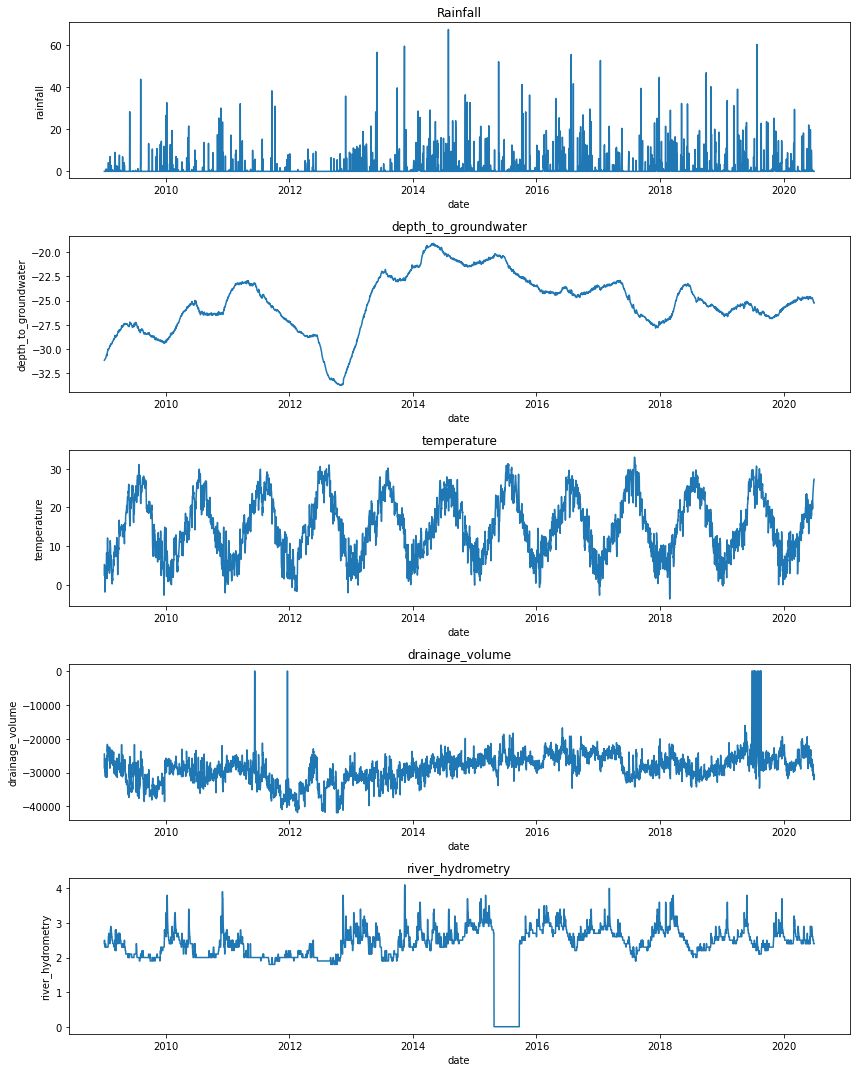

In [7]:
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (12,15))

sns.lineplot(ax=ax[0],x = df['date'],y = df['rainfall'])
ax[0].set_title('Rainfall')
sns.lineplot(ax=ax[1],x = df['date'],y = df['depth_to_groundwater'])
ax[1].set_title('depth_to_groundwater')
sns.lineplot(ax=ax[2],x = df['date'],y = df['temperature'])
ax[2].set_title('temperature')
sns.lineplot(ax=ax[3],x=df['date'],y = df['drainage_volume'])
ax[3].set_title('drainage_volume')
sns.lineplot(ax=ax[4],x = df['date'],y = df['river_hydrometry'])
ax[4].set_title('river_hydrometry')

plt.tight_layout()

### Make sure the data is equidistant in timestamp

In [8]:
df['date_dist'] = df['date'] - df['date'].shift(1)
df['date_dist'].sum(), len(df)

(Timedelta('4198 days 00:00:00'), 4199)

## Missing data
A few ways to fill missing data
- Fill NAN with zero
- Fill NAN with statistic ex: median or mean
- Fill NAN with interpolated value
- Fill NAN with most frequent (mode)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df.isnull().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
date_dist                1
dtype: int64

In [11]:
import numpy as np

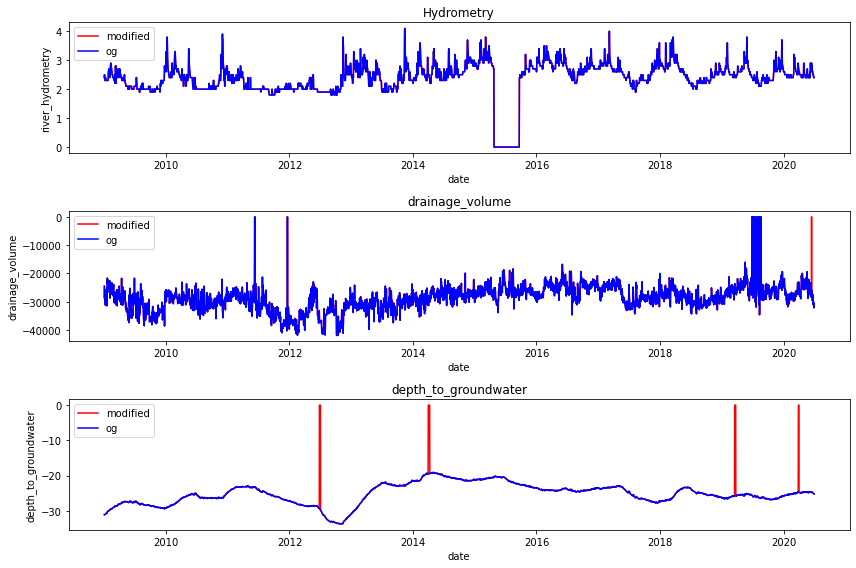

In [12]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize = (12,8))

og_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0,np.nan)

og_groundwater = df['depth_to_groundwater']
df['depth_to_groundwater'] = df['depth_to_groundwater'].replace(0,np.nan)

og_drainage = df['drainage_volume']
df['drainage_volume'] = df['drainage_volume'].replace(0,np.nan)

sns.lineplot(ax=ax[0], x = df['date'], y = df['river_hydrometry'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[0], x = df['date'], y = og_hydrometry, color = 'blue', label = 'og')
ax[0].set_title('Hydrometry')

sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[1], x = df['date'], y = og_drainage, color = 'blue', label = 'og')
ax[1].set_title('drainage_volume')

sns.lineplot(ax=ax[2], x = df['date'], y = df['depth_to_groundwater'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[2], x = df['date'], y = og_groundwater, color = 'blue', label = 'og')
ax[2].set_title('depth_to_groundwater')

plt.tight_layout()

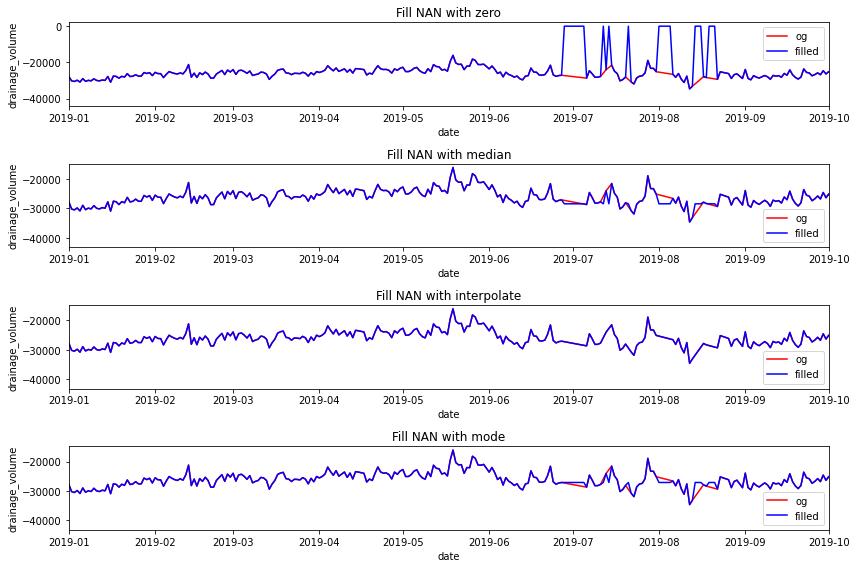

In [13]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (12,8))

sns.lineplot(ax=ax[0], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[0], x = df['date'], y = df['drainage_volume'].fillna(0), color = 'blue', label = 'filled')
ax[0].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[0].set_title('Fill NAN with zero')

sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].median()), color = 'blue', label = 'filled')
ax[1].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[1].set_title('Fill NAN with median')

sns.lineplot(ax=ax[2], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[2], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].interpolate()), color = 'blue', label = 'filled')
ax[2].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[2].set_title('Fill NAN with interpolate')

sns.lineplot(ax=ax[3], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[3], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].mode()[0]), color = 'blue', label = 'filled')
ax[3].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[3].set_title('Fill NAN with mode')

plt.tight_layout()

In [14]:
# Visually interpolation looks to be the best method to fill data
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

In [15]:
df.isnull().sum()

date                    0
rainfall                0
depth_to_groundwater    0
temperature             0
drainage_volume         0
river_hydrometry        0
date_dist               1
dtype: int64

### Resampling can also be a good way to visualize the data for insights.
If the frequency of data is too high, somethimes it is good to resample the data. ex: Downsample to view less overwhelming data for patterns.
- Upsampling: days to hours data.
- Downsampling hours to day or month data.
Note: It is situational to use mean or sum or other statistical method to resample the data. EX: For temperature, it makes more sense to use mean,and for drainage volume, it might make mor sense to use sum depending on what we are looking for.
From downsampling we are able to smooth the data and analyze the data more easily without noise.

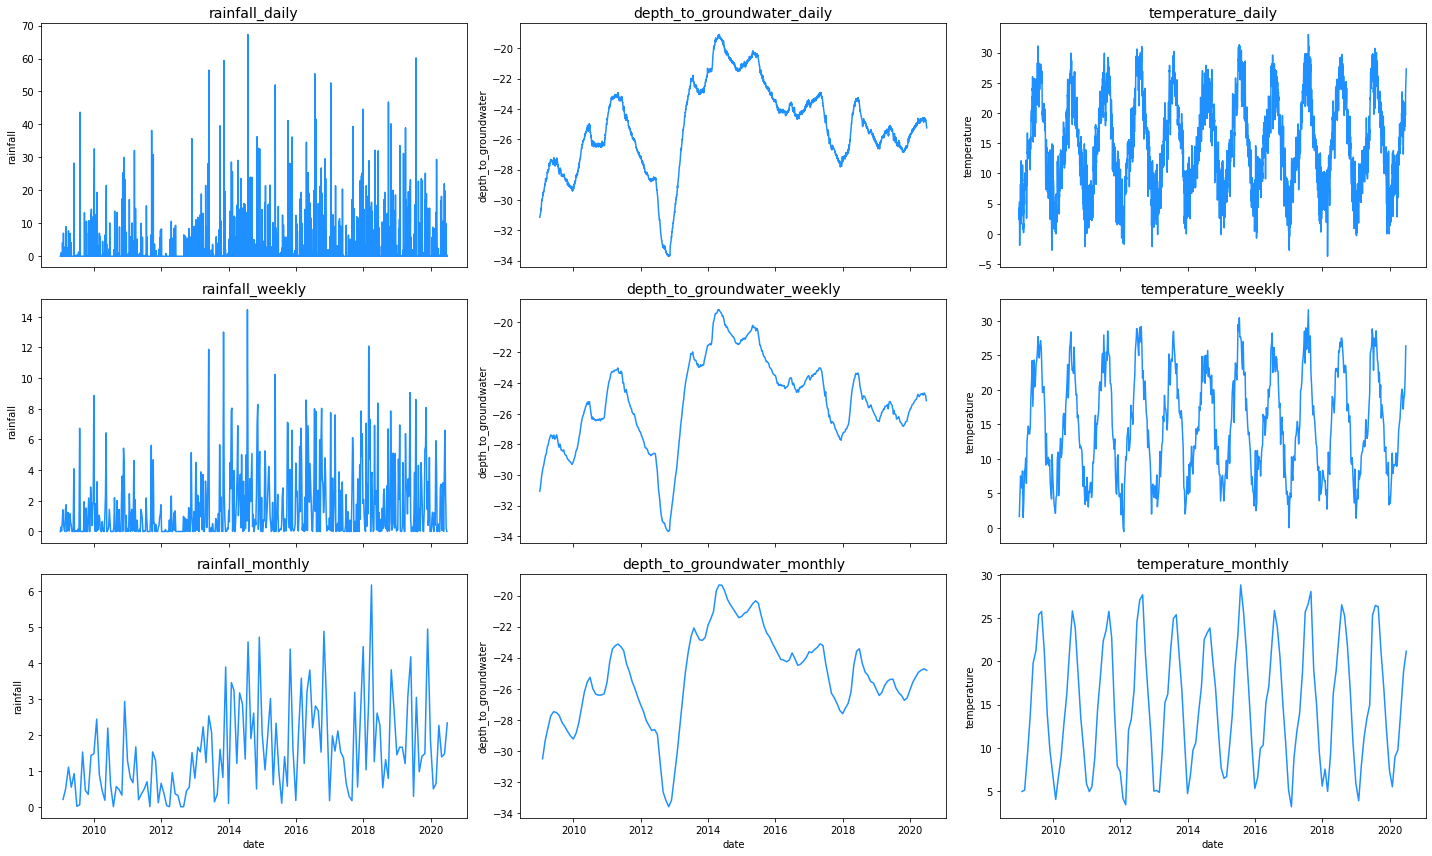

In [16]:
resample_week_df = df[['date','rainfall','depth_to_groundwater','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
resample_month_df = df[['date','rainfall','depth_to_groundwater','temperature']].resample('M', on='date').mean().reset_index(drop=False)

fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(20,12))

sns.lineplot(x = df['date'], y = df['rainfall'], color='dodgerblue', ax=ax[0,0])
sns.lineplot(x = resample_week_df['date'], y = resample_week_df['rainfall'], color='dodgerblue', ax=ax[1,0])
sns.lineplot(x = resample_month_df['date'], y = resample_month_df['rainfall'], color='dodgerblue', ax=ax[2,0])
ax[0, 0].set_title('rainfall_daily', fontsize=14)
ax[1, 0].set_title('rainfall_weekly', fontsize=14)
ax[2, 0].set_title('rainfall_monthly', fontsize=14)



sns.lineplot(x = df['date'], y = df['depth_to_groundwater'], color='dodgerblue', ax=ax[0,1])
sns.lineplot(x = resample_week_df['date'], y = resample_week_df['depth_to_groundwater'], color='dodgerblue', ax=ax[1,1])
sns.lineplot(x = resample_month_df['date'], y = resample_month_df['depth_to_groundwater'], color='dodgerblue', ax=ax[2,1])
ax[0, 1].set_title('depth_to_groundwater_daily', fontsize=14)
ax[1, 1].set_title('depth_to_groundwater_weekly', fontsize=14)
ax[2, 1].set_title('depth_to_groundwater_monthly', fontsize=14)


sns.lineplot(x = df['date'], y = df['temperature'], color='dodgerblue', ax=ax[0,2])
sns.lineplot(x = resample_week_df['date'], y = resample_week_df['temperature'], color='dodgerblue', ax=ax[1,2])
sns.lineplot(x = resample_month_df['date'], y = resample_month_df['temperature'], color='dodgerblue', ax=ax[2,2])
ax[0, 2].set_title('temperature_daily', fontsize=14)
ax[1, 2].set_title('temperature_weekly', fontsize=14)
ax[2, 2].set_title('temperature_monthly', fontsize=14)


plt.tight_layout()

In [17]:
df = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False) # transform data to weekly for easier analysis and faster computation in model training

# Feature Engineering
- Parsing date into different columns
- Time series decompisition
- Lag (Diff)

## Time series decomposition
Time series can be think of a combination of
- Level: The average value of the time series
- Trend: The increasing or decreasing value in the series
- Seasonality: The small repeating cycles
- Noise: The random variation

Two common compositions are
- Additive composition -> The above components are additive. (Visually when amplitude our constant)
- Multiplicative compsition -> The above components are multiplied (Visually when amplitude our increasing)

I will be building pseudo time series to better understand the decomposition.

Choosing the correct period to decompse the time series is key. A period should be the total time step that is to complete one seasonal cycle.
For example: In the example below, 10 sine waves are created in a time series that has a total of 100 time steps. Therefore, the period should be 10. because it takes 10 time steps in total to complete one seasonal cycle.

In [18]:
time_step = 101

psuedo_trend = np.array([ i for i in range(0,time_step)])

T = 10
time = np.arange(time_step)
psuedo_seasonality =  np.sin((2 * np.pi  / T)*time) * 10

mean = 0
std = 3
psuedo_noise = np.random.normal(mean, std, size=time_step)

pseudo_add_time_series = psuedo_trend + psuedo_seasonality + psuedo_noise
pseudo_mult_time_series = psuedo_trend * psuedo_seasonality * psuedo_noise


In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

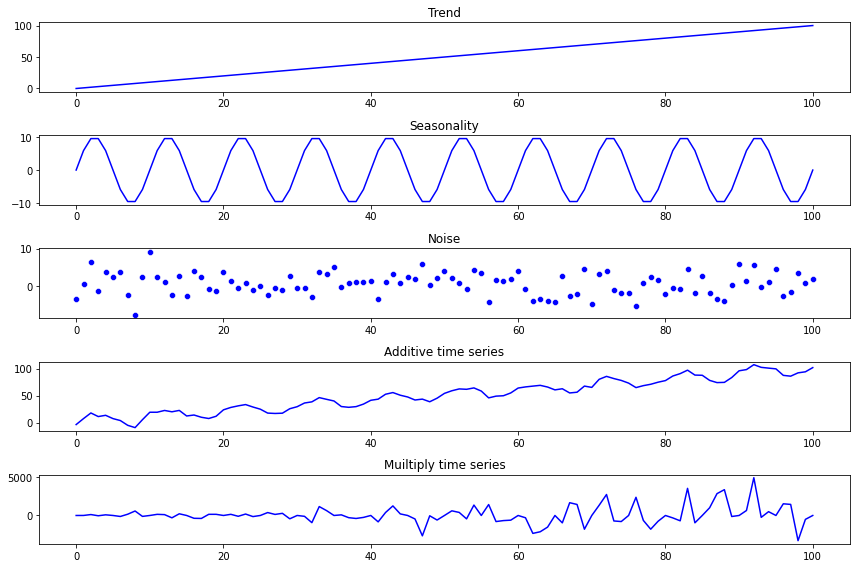

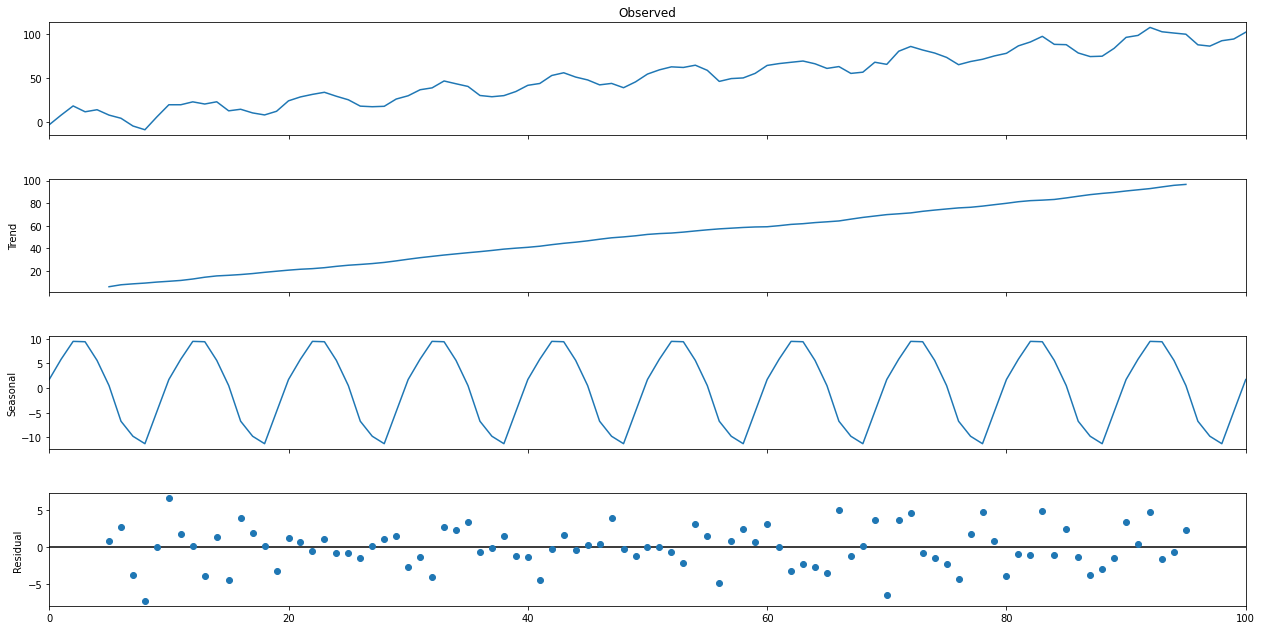

In [20]:
fig , ax = plt.subplots(nrows = 5, ncols = 1,figsize = (12,8))

sns.lineplot(ax=ax[0], data = psuedo_trend, color = 'blue')
ax[0].set_title('Trend')

sns.lineplot(ax=ax[1], data = psuedo_seasonality, color = 'blue')
ax[1].set_title('Seasonality')

sns.scatterplot(ax=ax[2], data = psuedo_noise, color = 'blue')
ax[2].set_title('Noise')

sns.lineplot(ax=ax[3], data = pseudo_add_time_series, color = 'blue')
ax[3].set_title('Additive time series')

sns.lineplot(ax=ax[4], data = pseudo_mult_time_series, color = 'blue')
ax[4].set_title('Muiltiply time series')

plt.tight_layout()

decompose_value = seasonal_decompose(pseudo_add_time_series, model='additive',period = 10) # choosing the coorect period is key to the decomposition

fig = decompose_value.plot()
fig.set_size_inches((20, 10))

# decompose_value = seasonal_decompose(pseudo_add_time_series, model='multiplicative',period = 10)
# fig = decompose_value.plot()
# fig.set_size_inches((20, 10))


In [21]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter

C:\Users\User\AppData\Local\Temp\ipykernel_19712\867297069.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear


### Seasonal decomposition
Earlier we mentioned that the most important parameter is the "Period". However, most often times the period is unkown it should be tested out. I n our case, "temperature" is the easiest column to determine a good period.Therefore, we will be using that period for all other columns we could like to decompose for convenience.

<AxesSubplot:xlabel='date', ylabel='temperature'>

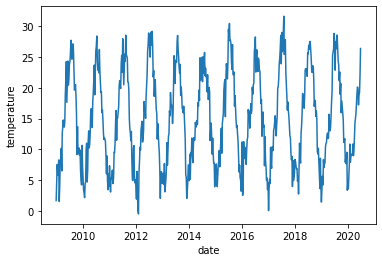

In [22]:
sns.lineplot( x = df['date'], y = df['temperature'])
# according to the plot. temperature has a annual period which is intuitive, so we will use period of 52.Since a year has around 52 weeks

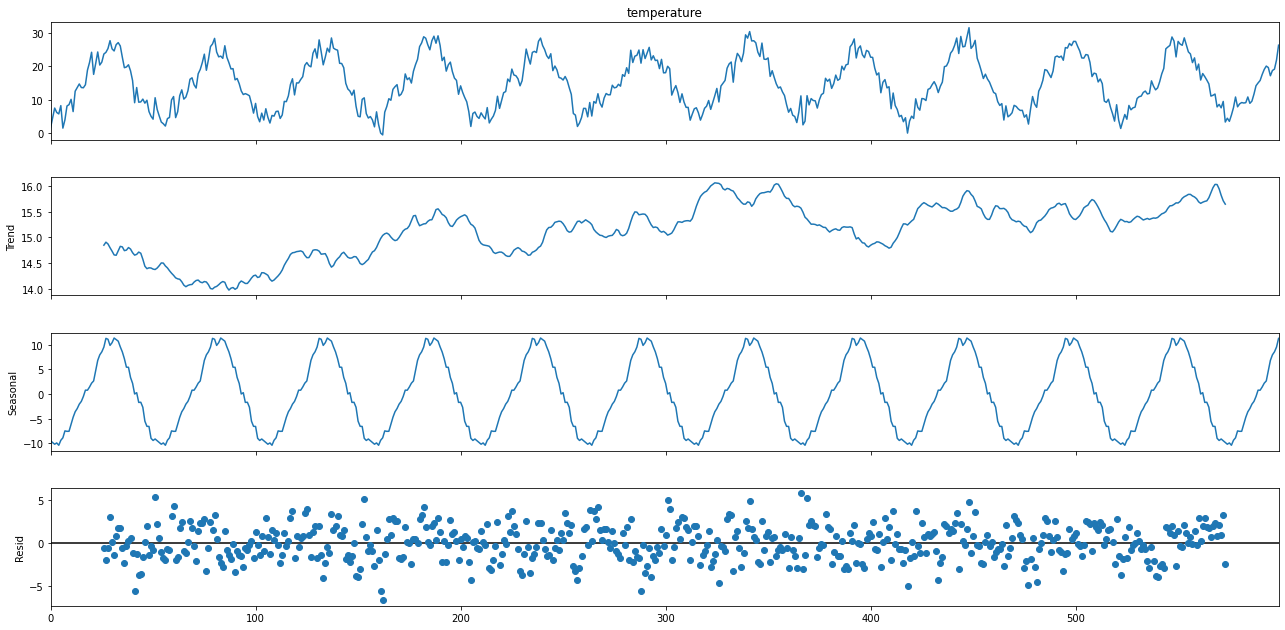

In [23]:
decompose_value = seasonal_decompose(df['temperature'], model='additive',period = 52)  
fig = decompose_value.plot()
fig.set_size_inches((20, 10))

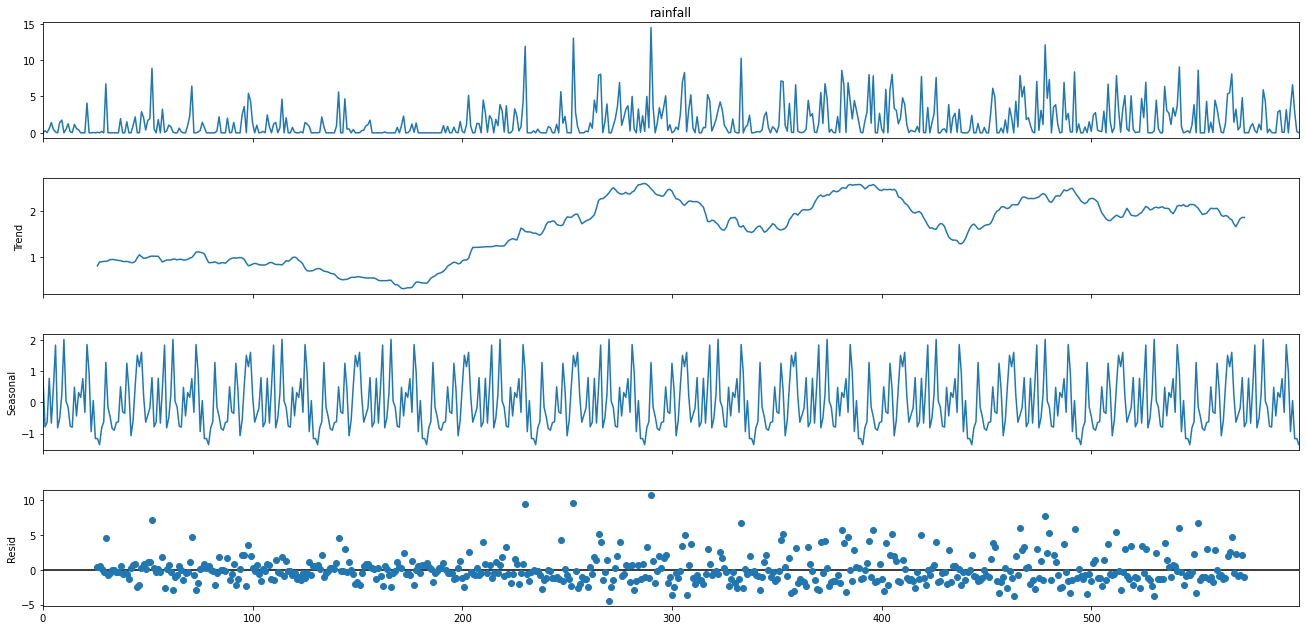

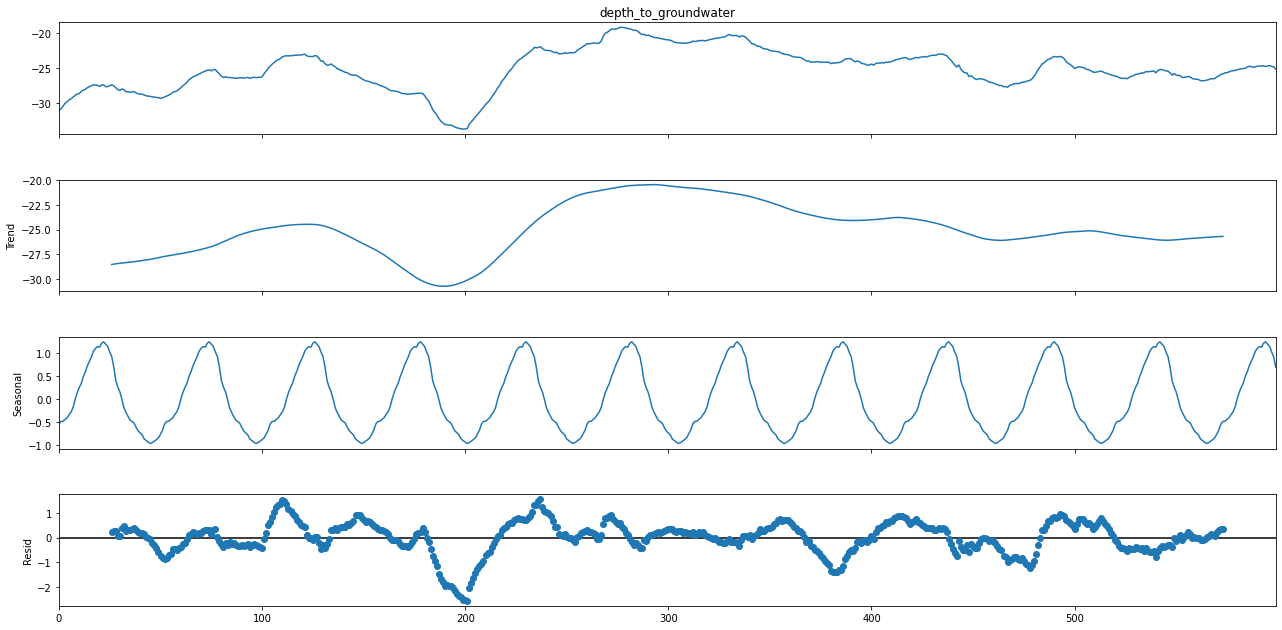

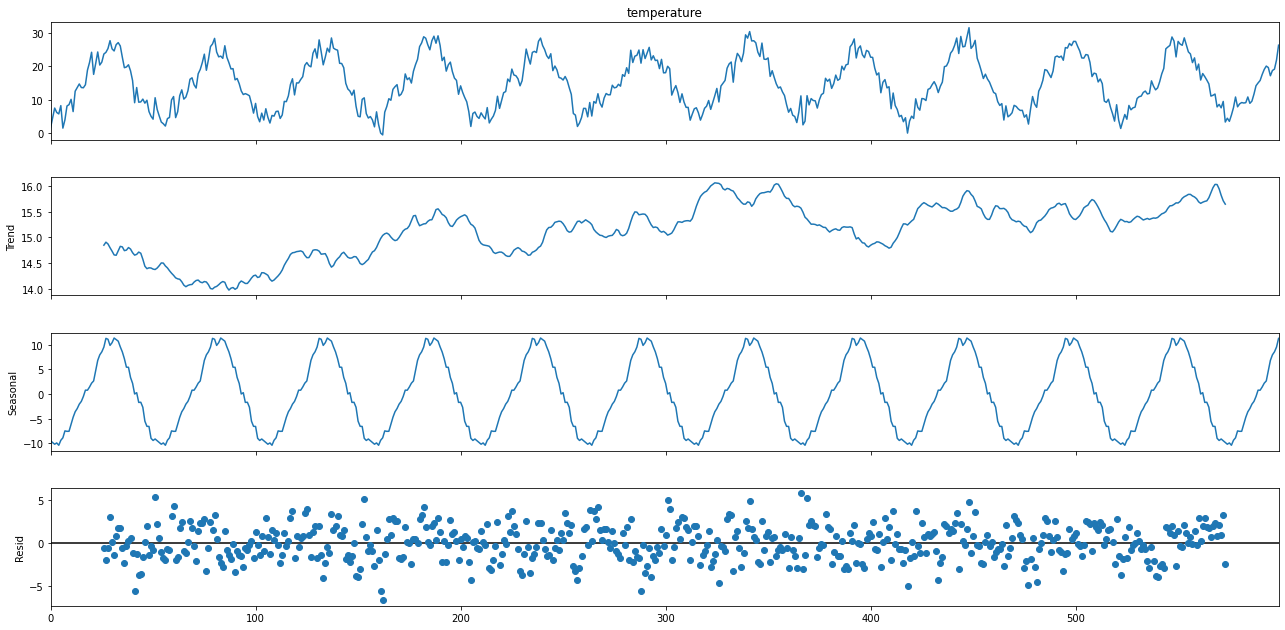

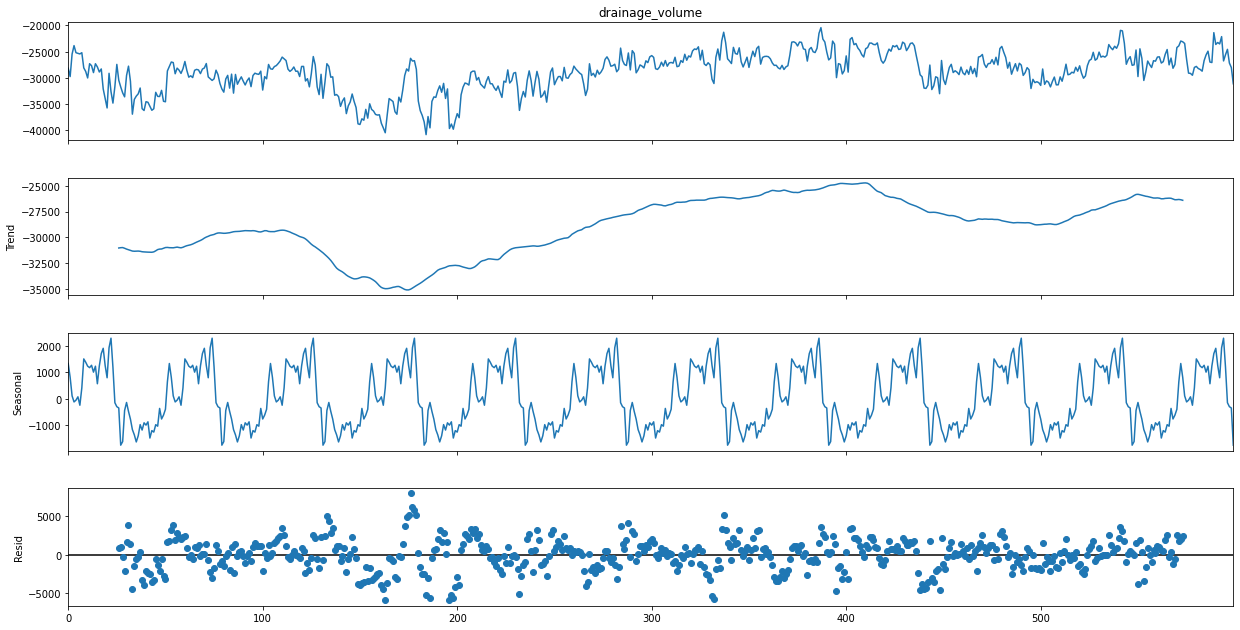

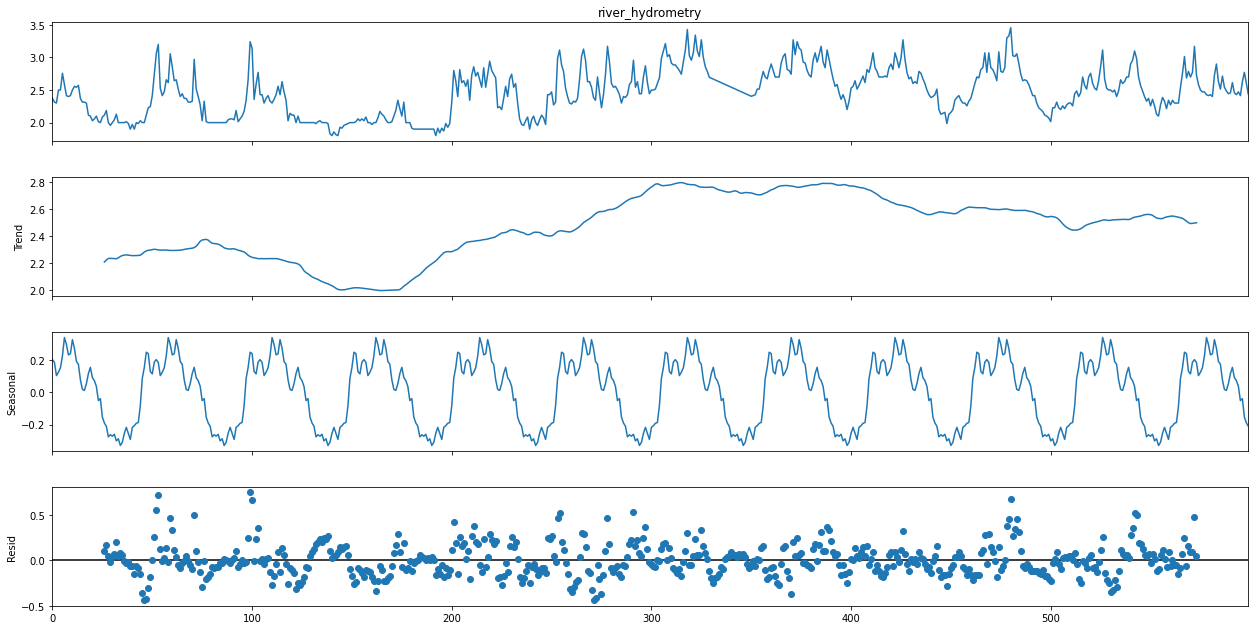

In [24]:
cols_to_decompose = ['rainfall', 'depth_to_groundwater', 'temperature',
       'drainage_volume', 'river_hydrometry']
for columns in cols_to_decompose:
    decompose_value = seasonal_decompose(df[columns], model='additive',period = 52)
    df[f"{columns}_trend"] = decompose_value.trend
    df[f"{columns}_seasonal"] = decompose_value.seasonal
    fig = decompose_value.plot()
    fig.set_size_inches((20, 10))


# Stationarity
Some models such as the ARIMA model assumes the data to be staionary. When a time series is staionary the statistical properties does not change over time.
- the mean and variance does not chamge over time

And to check for staionarity
- Plot the data out and check visually
- Split the time series into sections and compare the mean and variance for each section
- Augmented Dickey Fuller test statistical testing

Looking at 'temperature' and our target 'depth_to_groundwater'. Temperature has mean and std close to constant, so it is more staionary than depth_to_groundwater since mean and std for depth_to_groundwater changes more through time.

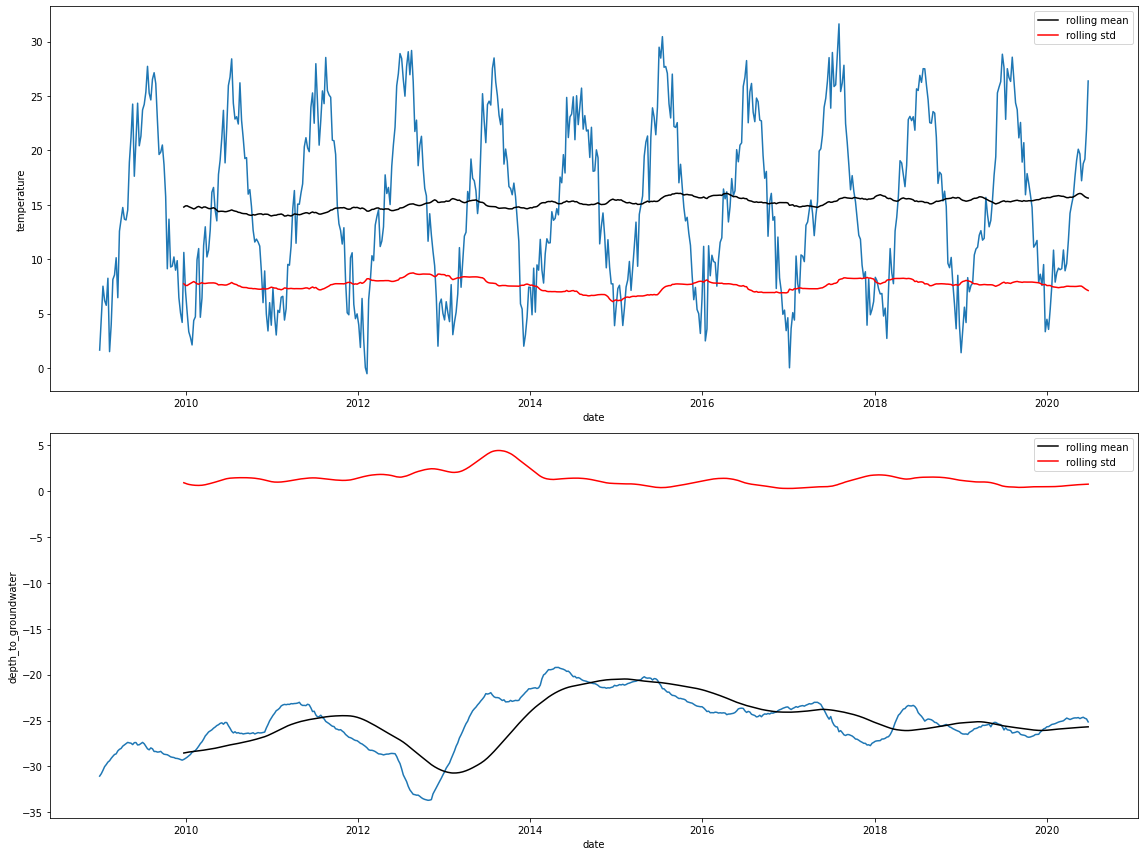

In [25]:
rolling_window = 52

fig, ax= plt.subplots(nrows = 2, ncols = 1, figsize = (16,12))

sns.lineplot(ax = ax[0], x = df['date'],y = df['temperature'])
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[0], color='red', label='rolling std')

sns.lineplot(ax = ax[1], x = df['date'],y = df['depth_to_groundwater'])
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].rolling(rolling_window).std(), ax=ax[1], color='red', label='rolling std')

plt.tight_layout()

### Augmented Dickey Fuller test
The ADF test is a hypothesis test to check if a time series is stationary.
- Null: The time series is not staionary. It has a unit root
- Alternative: The time series is stationary.

**p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

Other criteria to test for unit root

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
col_lst= ['rainfall', 'depth_to_groundwater', 'temperature','drainage_volume', 'river_hydrometry']
SI = 0.05
for col in col_lst:
    stat_result = adfuller(df[col])
    adf_stat = stat_result[0]
    pvalue = stat_result[1]
    critical_val_1 = stat_result[4]['1%'] 
    critical_val_5 = stat_result[4]['5%']
    critical_val_10 = stat_result[4]['10%']
    print(f'The {col} ADF results: adf_stat:{adf_stat}, pvalue = {pvalue}\n critical_val_1 = {critical_val_1}, critical_val_5 = {critical_val_5}, critical_val_10 = {critical_val_10}')
    
    if (pvalue < SI) & ((adf_stat < critical_val_1)):
         print('column is staitionary')
    elif (pvalue < SI) & (adf_stat < critical_val_5):
        print('column fails second criteria')
    elif (pvalue < SI) & (adf_stat < critical_val_10):
        print('column fails second criteria')
    else:
        print('column is not staitionary')
    print('=================================================================')


The rainfall ADF results: adf_stat:-3.3739124992536365, pvalue = 0.011880998999360572
 critical_val_1 = -3.4415970480373046, critical_val_5 = -2.866501759246704, critical_val_10 = -2.5694124827594296
column fails second criteria
The depth_to_groundwater ADF results: adf_stat:-2.880201649316666, pvalue = 0.04769919092020815
 critical_val_1 = -3.441444394224128, critical_val_5 = -2.8664345376276454, critical_val_10 = -2.569376663737217
column fails second criteria
The temperature ADF results: adf_stat:-12.03437020153245, pvalue = 2.825673334244129e-22
 critical_val_1 = -3.441635870156286, critical_val_5 = -2.866518854162241, critical_val_10 = -2.569421591856497
column is staitionary
The drainage_volume ADF results: adf_stat:-3.0098295743646823, pvalue = 0.033986582654891365
 critical_val_1 = -3.4414821678603946, critical_val_5 = -2.8664511716874657, critical_val_10 = -2.5693855271473716
column fails second criteria
The river_hydrometry ADF results: adf_stat:-4.8239060315452695, pvalue = 

### Feature engineering for stationarity
According to our test, depth_to_groundwater is not staionary. There are main two methods to engineer for staionarity.
- Transforming: some transformation includes log, square root, cubed root ...etc. Used to stabilize the non-constant variance of a series.
- Differencing: the process subtracting the value of one observation with the value of another observation x number of periods ago, where x is the time period lag. Differencing is typically performed to get rid of the varying mean.
In the diff plot below, the Mean is closer to constant compared to the oringinal.

The depth_to_groundwater ADF results: adf_stat:-2.880201649316666, pvalue = 0.04769919092020815
 critical_val_1 = -3.441444394224128, critical_val_5 = -2.8664345376276454, critical_val_10 = -2.569376663737217
column fails second criteria
The depth_to_groundwater_trans ADF results: adf_stat:-2.947289650408221, pvalue = 0.04011876281973688
 critical_val_1 = -3.4414256033746606, critical_val_5 = -2.8664262627821473, critical_val_10 = -2.569372254520843
column fails second criteria
The depth_to_groundwater_diff ADF results: adf_stat:-5.14964382879204, pvalue = 1.1130396636935261e-05
 critical_val_1 = -3.4414256033746606, critical_val_5 = -2.8664262627821473, critical_val_10 = -2.569372254520843
column is staitionary


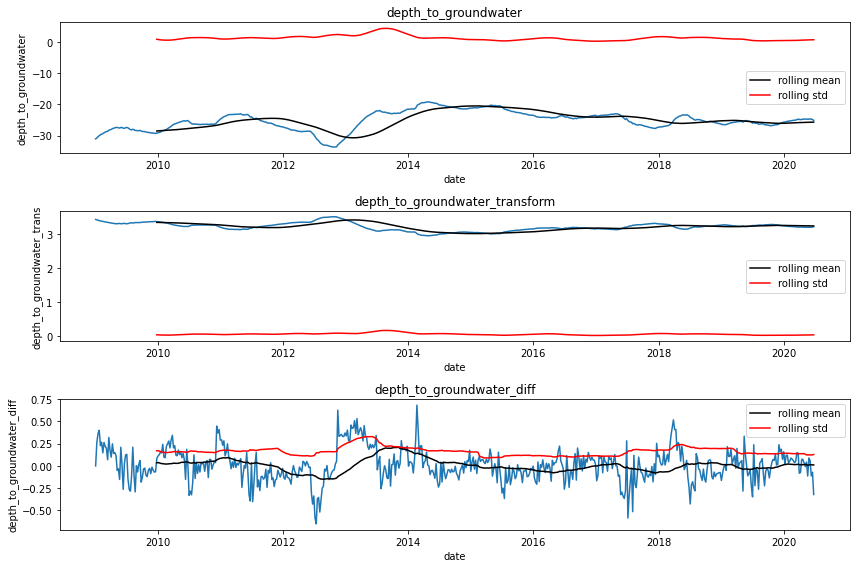

In [28]:
df['depth_to_groundwater_trans'] = np.log(abs(df['depth_to_groundwater']))
df['depth_to_groundwater_diff'] = np.append([0], np.diff(df['depth_to_groundwater']))
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (12,8))


sns.lineplot(x = df['date'],y= df['depth_to_groundwater'],ax = ax[0])
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater'].rolling(rolling_window).std(), ax=ax[0], color='red', label='rolling std')
ax[0].set_title('depth_to_groundwater')

sns.lineplot(x = df['date'],y= df['depth_to_groundwater_trans'],ax = ax[1])
sns.lineplot(x=df['date'], y=df['depth_to_groundwater_trans'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater_trans'].rolling(rolling_window).std(), ax=ax[1], color='red', label='rolling std')
ax[1].set_title('depth_to_groundwater_transform')

sns.lineplot(x = df['date'],y= df['depth_to_groundwater_diff'],ax = ax[2])
sns.lineplot(x=df['date'], y=df['depth_to_groundwater_diff'].rolling(rolling_window).mean(), ax=ax[2], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['depth_to_groundwater_diff'].rolling(rolling_window).std(), ax=ax[2], color='red', label='rolling std')
ax[2].set_title('depth_to_groundwater_diff')

plt.tight_layout()

col_lst = ['depth_to_groundwater','depth_to_groundwater_trans','depth_to_groundwater_diff']
for col in col_lst:
    stat_result = adfuller(df[col])
    adf_stat = stat_result[0]
    pvalue = stat_result[1]
    critical_val_1 = stat_result[4]['1%'] 
    critical_val_5 = stat_result[4]['5%']
    critical_val_10 = stat_result[4]['10%']
    print(f'The {col} ADF results: adf_stat:{adf_stat}, pvalue = {pvalue}\n critical_val_1 = {critical_val_1}, critical_val_5 = {critical_val_5}, critical_val_10 = {critical_val_10}')
    
    if (pvalue < SI) & ((adf_stat < critical_val_1)):
         print('column is staitionary')
    elif (pvalue < SI) & (adf_stat < critical_val_5):
        print('column fails second criteria')
    elif (pvalue < SI) & (adf_stat < critical_val_10):
        print('column fails second criteria')
    else:
        print('column is not staitionary')
    print('=================================================================')

# Autocorrelation analysis
 After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. The autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the **differenced series** are used to determine the correct oarameters to use.

- Autocorrelation function (ACF): Refers to the degree of correlation of the same variables between two successive time intervals
- Partial autocorrelation (PACF): Displays only the correlation between two observations that the shorter lags between those observations do not explain. EX: The partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain.

Interpreting ACF and PACF 
1. Look for tail off pattern in either ACF or PACF.
2. If tail off at ACF → AR model → Cut off at PACF will provide order p for AR(p).
3. If tail off at PACF → MA model → Cut off at ACF will provide order q for MA(q).
4. Tail of at both ACF and PACF → ARMA model

Another way would be to autogerenate the best parameters using Auto-ARIMA.

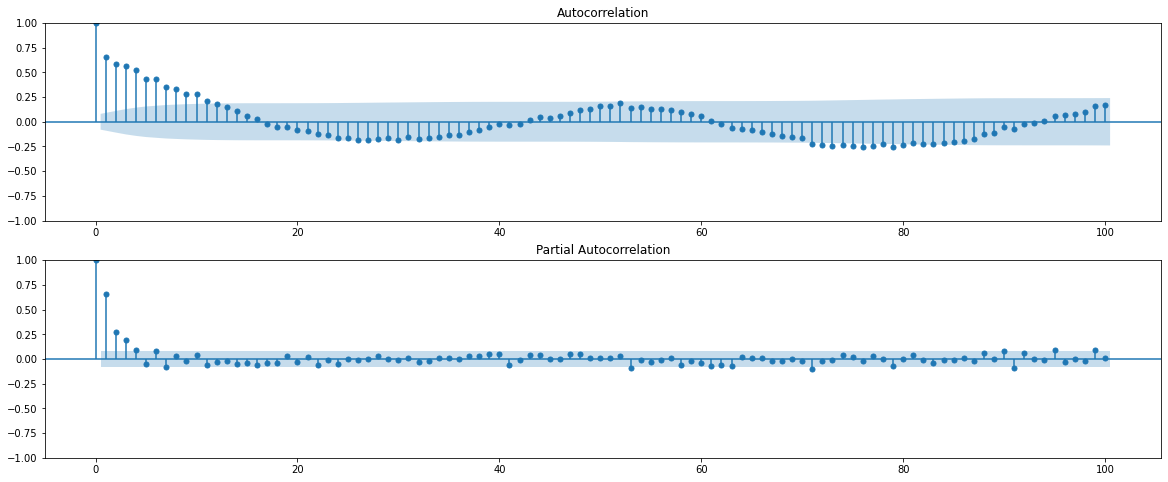

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20,8))
plot_acf(df['depth_to_groundwater_diff'],lags = 100,ax = ax[0])
plot_pacf(df['depth_to_groundwater_diff'],lags = 100,ax = ax[1])
plt.show()

# Model
Modeling time series can either be 
- Univariate: Single time-dependent variable.
- Multivariate: Multiple time-dependent variable.
### Splitting data
Time series data is characterized by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation techniques such as KFold and ShuffleSplit assume the samples are independent and identically distributed, and would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalization error) on time series data.

```TimeSeriesSplit``` is a function that splits time series data. It is a variation of k-fold which returns first k folds as train set and the (k+1)
 th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.
 
 In the below example, we have a two independent variables with 10 time steps, and one dependent variable with 10 timesteps. The data would be split into 2 folds and 5 folds respectively, and index for the training and validation set print out.


In [30]:
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [30, 40], [1, 2], [20, 30], [1, 2], [80, 90], [1, 2], [50, 60], [1, 2], [10, 20]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
test_folds = TimeSeriesSplit(n_splits=2)
print('2 folds were created')
for i, (train_index, valid_index) in enumerate(test_folds.split(X)):
    print(train_index,valid_index)

print('========================================================================')
print('5 folds were created')
test_folds = TimeSeriesSplit(n_splits=5)
for i, (train_index, valid_index) in enumerate(test_folds.split(X)):
    print(train_index,valid_index)



2 folds were created
[0 1 2 3] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]
5 folds were created
[0 1 2 3 4] [5]
[0 1 2 3 4 5] [6]
[0 1 2 3 4 5 6] [7]
[0 1 2 3 4 5 6 7] [8]
[0 1 2 3 4 5 6 7 8] [9]


In [31]:
N_SPLITS = 4

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

The dates interval being used for training the 1 fold on the left side plot is from 2009-01-01 00:00:00 to 2011-04-14 00:00:00
The dates interval being used for training the 2 fold on the left side plot is from 2009-01-01 00:00:00 to 2013-08-01 00:00:00
The dates interval being used for training the 3 fold on the left side plot is from 2009-01-01 00:00:00 to 2015-11-19 00:00:00
The dates interval being used for training the 4 fold on the left side plot is from 2009-01-01 00:00:00 to 2018-03-08 00:00:00


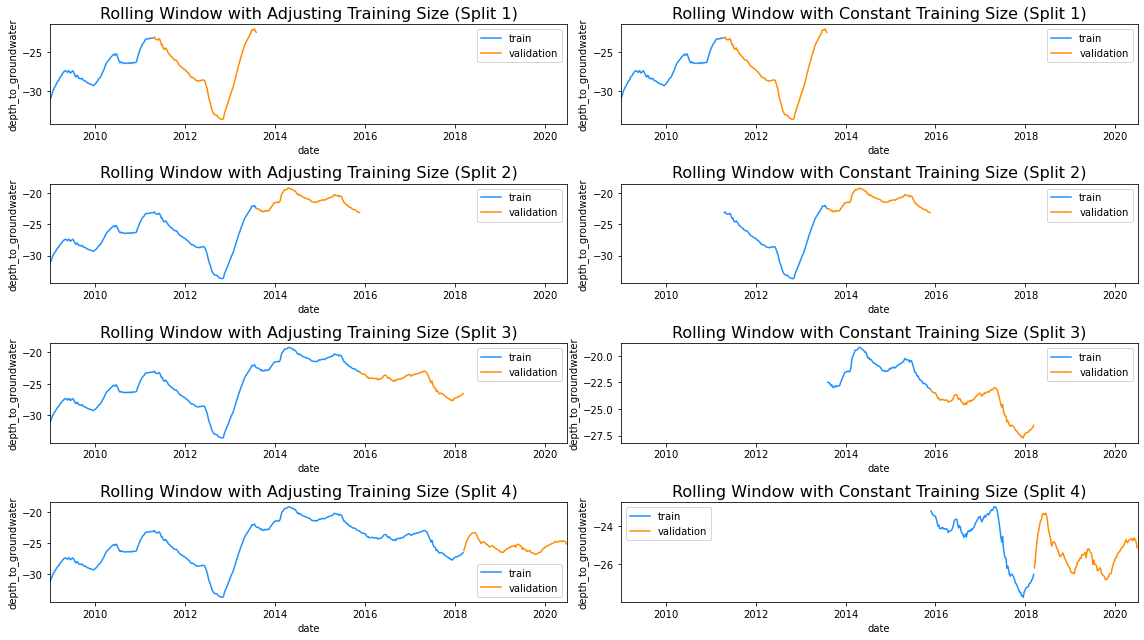

In [32]:
fig, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    print(f'The dates interval being used for training the {i+1} fold on the left side plot is from {X[train_index][0]} to {X[train_index[-1]]}')
    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

# Univariate models

In [186]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


### AUTO-ARIMA

In [187]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-631.136, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-242.692, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.047, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-427.347, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-243.054, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-629.209, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-629.237, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-492.779, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-611.065, Time=0.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-628.351, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-632.995, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-428.258, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-575.735, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-631.069, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]          

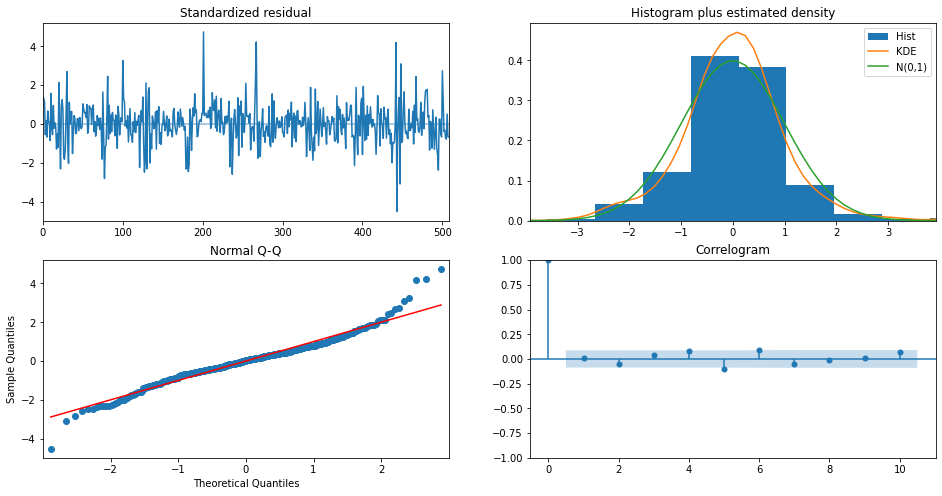

In [188]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

# ARIMA

In [189]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

y_hat_arima = model_fit.forecast(90)
y_hat_arima

510   -25.687034
511   -25.802535
512   -25.908744
513   -26.006409
514   -26.096217
         ...    
595   -27.121604
596   -27.121696
597   -27.121782
598   -27.121860
599   -27.121932
Name: predicted_mean, Length: 90, dtype: float64

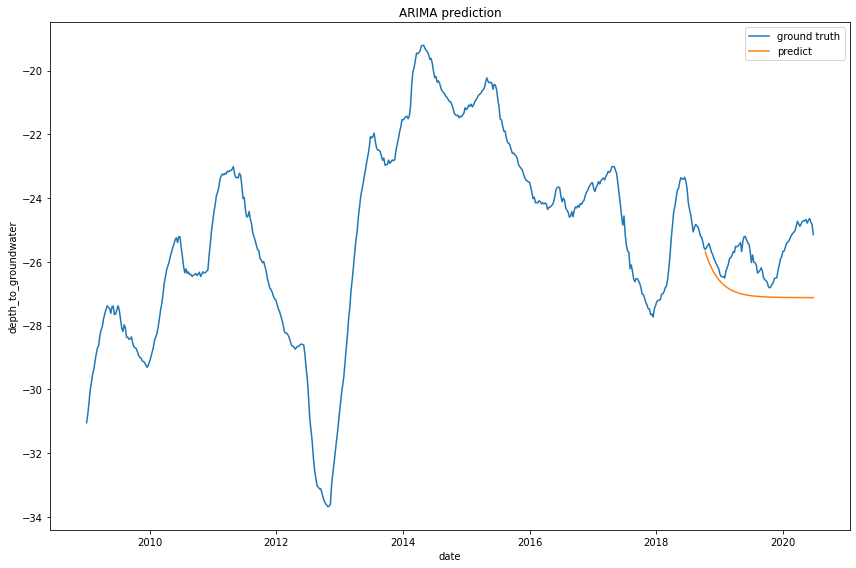

In [192]:
f, ax = plt.subplots(1,figsize = (12,8))

test_df = df[train_size:]
test_df = test_df[['date','depth_to_groundwater']]
test_df['y_hat_arima'] = y_hat_arima
sns.lineplot(x = df['date'],y = df['depth_to_groundwater'], label = 'ground truth')

sns.lineplot(x = test_df['date'],y = test_df['y_hat_arima'], label = 'predict')
ax.set_title('ARIMA prediction')
plt.tight_layout()

plt.show()

### LSTM
LSTM are long short term memory neural networks architectures used for processing sequencual data.
The most important part of building an LSTM model is to understand the model is using previous time steps as features to predict the future. And the number of time steps to look back as features are called the "look back period".

EX: time_series = [10,20,30,40,50,60,70,80,90]. A look back period of 5 and a model that predicts one time step into the future would need the below training data.

[10,20,30,40,50] -> [60]

[20,30,40,50,60] -> [70]

[30,40,50,60,70] -> [80]

[40,50,60,70,80] -> [90]

the training matrix would have a shape of (4,5,1) # (num_samples, num_timesteps, num_features)

Below we will start building the model pipeline.
- Normalize (Using MinMax Scaler since the target variable is not Gaussian Distribution)
- Split data into train and validation set
- Convert array into tensor
- Reshape into X = t, y = t + 1
- Reshape input to be 3D (num_samples, num_timesteps, num_features)

In [94]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = univariate_df.filter(['y'])
scaled_data = scaler.fit_transform(data.values)
print(scaled_data)


[[0.18203356]
 [0.20029615]
 [0.2254689 ]
 [0.25320829]
 [0.26900296]
 [0.28746298]
 [0.2976308 ]
 [0.31589339]
 [0.33109576]
 [0.34471866]
 [0.34945706]
 [0.3715696 ]
 [0.38361303]
 [0.39042448]
 [0.40760118]
 [0.41727542]
 [0.42764067]
 [0.43563672]
 [0.43208292]
 [0.42981244]
 [0.41924975]
 [0.43376111]
 [0.43474827]
 [0.41648569]
 [0.41816387]
 [0.42675222]
 [0.43573544]
 [0.42537019]
 [0.4071076 ]
 [0.38746298]
 [0.3798618 ]
 [0.39437315]
 [0.3875617 ]
 [0.36732478]
 [0.36752221]
 [0.36278381]
 [0.36396841]
 [0.36811451]
 [0.35547878]
 [0.34679171]
 [0.34442251]
 [0.34274432]
 [0.33553801]
 [0.32714709]
 [0.32379072]
 [0.3219151 ]
 [0.31589339]
 [0.31490622]
 [0.31154985]
 [0.30671273]
 [0.30217177]
 [0.30779862]
 [0.3153998 ]
 [0.32408687]
 [0.33455084]
 [0.34471866]
 [0.36150049]
 [0.36831194]
 [0.37462981]
 [0.38973346]
 [0.40691017]
 [0.42625864]
 [0.44027641]
 [0.46051333]
 [0.48430405]
 [0.49832182]
 [0.51401777]
 [0.52230997]
 [0.53020731]
 [0.54254689]
 [0.55133268]
 [0.56

### Preparing the dataset for training
Since we have weekly data, we will set the look back period to be 52. Which means the model will look at a sequence of 52 timesteps as input to predict the output.
Our scaled data has a length of 600, and our training size was previously defined to be 85% of the total data length which is 600 x 0.85 = 510. Our test set is the 15% of the data rest of the data which is 600 x 0.15 = 90.
In the training data, we will also split 15% as validation (510 x 0.15 = 77). Therefore the training data will have 510-69 =  441 samples. The file shape for training (433,52,1), validation (77,52,1), and testing(90,52,1)

In [95]:
look_back_period = 52
train_per,test_per = int(len(scaled_data) * 0.85) ,len(scaled_data) * 0.15
train, test = scaled_data[:train_per], scaled_data[train_per:]

val_per = int(len(train) * 0.15)
train, val = train[:-val_per], train[-val_per:]
print(f'training data: {len(train)}, validation data: {len(val)}, testing data: {len(test)}')


training data: 434, validation data: 76, testing data: 90


In [96]:
def data_input(dataset, look_back_period):
    X, Y = [], []
    for i in range(look_back_period, len(dataset)):
        a = dataset[i-look_back_period:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)


In [97]:
x_train,y_train = data_input(train,look_back_period = look_back_period)
x_val,y_val = data_input(val,look_back_period = look_back_period)
x_test,y_test = data_input(test,look_back_period = look_back_period)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(382, 52, 1) (382,)
(24, 52, 1) (24,)
(38, 52, 1) (38,)


### tensorflow also provides a nice function to prepare time series data

In [98]:
import tensorflow as tf

In [99]:
train_tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets = scaled_data[look_back_period:], # targets are three steps into the future
    sequence_length=look_back_period,
    batch_size=32
)

val_tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
    val,
    targets = scaled_data[look_back_period:], # targets are three steps into the future
    sequence_length=look_back_period,
    batch_size=32
)

test_tf_dataset = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets = scaled_data[look_back_period:], # targets are three steps into the future
    sequence_length=look_back_period,
    batch_size=32
)

### Building model
Building a LSTM model is complex topic and would be done as a seperate study.

In [100]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [101]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(look_back_period, 1)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [102]:
model.fit(x_train, y_train, epochs=5 , validation_data = (x_val,y_val), batch_size=1)
model.summary()

Epoch 1/5


382/382 [==============================] - 8s 17ms/step - loss: 0.0146 - val_loss: 0.0033
Epoch 2/5
382/382 [==============================] - 6s 16ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/5
382/382 [==============================] - 6s 16ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/5
382/382 [==============================] - 7s 18ms/step - loss: 0.0011 - val_loss: 9.1242e-04
Epoch 5/5
382/382 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 7.8635e-04
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 52, 128)           66560     
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                  

In [104]:
y_hat = model.predict(x_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

2/2 [==============================] - 0s 12ms/step


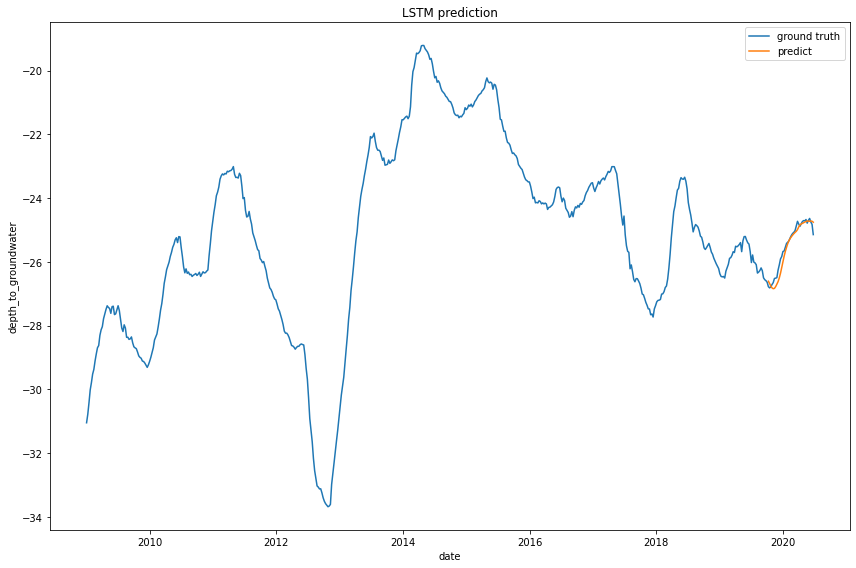

In [136]:
f, ax = plt.subplots(1,figsize = (12,8))

test_df = df[train_per + look_back_period:]
test_df = test_df[['date','depth_to_groundwater']]
test_df['y_hat_inverse'] = y_hat_inverse
sns.lineplot(x = df['date'],y = df['depth_to_groundwater'], label = 'ground truth')

sns.lineplot(x = test_df['date'],y = test_df['y_hat_inverse'], label = 'predict')
ax.set_title('LSTM prediction')
plt.tight_layout()

plt.show()

In [157]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
lstm_rmse = mean_squared_error(y_hat_inverse,scaler.inverse_transform(y_test.reshape(-1, 1)))
lstm_mae = mean_absolute_error(y_hat_inverse,scaler.inverse_transform(y_test.reshape(-1, 1)))
print(f'LSTM RMSE: {lstm_rmse}, LSTM MAE: {lstm_mae}')

LSTM RMSE: 0.03660680034525826, LSTM MAE: 0.14364776095053292


# Summary
Time series analysis is a specific way of analyzing a sequence of data points collected over time. In order to have a good understanding of the series, the frequency of datapoints should be fixed. A good way to grab initial intuition of the data is to plot the data in a lineplot and look for trends, seasonality... ect. To clean the data, and fit missing values. Some good practices include: linear interpolation, filling with mean or median, or even filling with zero. Like most data science projects, the best method depends on use case. 
### Decompisition
Decompisition is the process of splitting a time series signal into multiple components. This is a important part of time series anaylsis becasue classical models such as ARIMA rely on understanding the seasonality and trend to select suitable parameters.

Time series signal:
- Trend: The long term patter of a time serielong-term increase or decrease in the series.
- Seasonality: Regular fuctuation 
- Cyclical:　
- Noise: Unpredictable noise caused from measurement
